# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных**<br />
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. <br />
***Значение полей:***<br />
сalls — количество звонков,<br />
minutes — суммарная длительность звонков в минутах,<br />
messages — количество sms-сообщений,<br />
mb_used — израсходованный интернет-трафик в Мб,<br />
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).<br />

## Откройте и изучите файл

### Подготовительные работы

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

Отключение вывода в окно с прокруткой:

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Отключение settingwithcopywarning
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

### Загрузка данных

In [4]:
import pandas as pd
data = pd.read_csv('/datasets/users_behavior.csv')

### Информация о столбцах:

In [5]:
data_name = 'Данные об абонентах'
data_fields = {
'calls':'количество звонков',
'minutes':'суммарная длительность звонков в минутах',
'messages':'количество sms-сообщений',
'mb_used':'израсходованный интернет-трафик в Мб',
'is_ultra':'каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)',
}    


### Вспомогательные функции:

#### Функция, создающая таблицу по данным describe() для столбцов датафрейма

In [6]:
def describer(df,clmn='column'):
    df_describe = pd.DataFrame(columns=[clmn,'count','mean','std','min','25%','50%','75%','max'])
    for col in df.columns:
        param = df[col]
        typer = type(list(param)[0]) #[0])
        if (not 'str' in str(typer)) and (not 'bool' in str(typer)) and (not 'date' in str(typer)):
            desc = df[col].describe().to_dict()
            desc[clmn] = col
            df_describe = df_describe.append(desc, ignore_index=True)
    return df_describe

#### Функция получения информации о столбце

In [7]:
def col_reaper(ddf,param_name,plot_hist = True):
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    #Определение имени столбца
#    param_index = param.reset_index()
#    param_name = param_index.columns[1]
    if data_fields.get(param_name) is not None:
        field = data_fields.get(param_name)
    else:
        field = ''
        
    print('\033[1;3m' +  param_name + ' - ' + field + '\033[0m')

    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
    if plot_hist and not 'str' in str(typer):
#        print('\nГистограмма значений:')
        param.hist();
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',figsize=(16,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(16,5))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')

#### Функция получения информации о датафрейме

In [8]:
def df_reaper(df, df_name ='', fields = {}):
    #global df_name
    #global descript
    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    display(describer(df))
    
    print('\033[1m' +  'Диаграмма рассеивания:' + '\033[0m')
    pd.plotting.scatter_matrix(data, figsize=(12, 12)); 
    plt.show()
    
    print('\033[1m' +  'Корелляция данных:' + '\033[0m')
    display(df.corr())
    
    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
    cols = df.columns
    for col in cols:
        col_reaper(df,col)

### Анализ данных:

Данные об абонентах 

Количество записей:


3214


Первые 5 строк данных:


,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,"19,915.42",0
1,85.00,516.75,56.00,"22,696.96",0
2,77.00,467.66,86.00,"21,060.45",0
3,106.00,745.53,81.00,"8,437.39",1
4,66.00,418.74,1.00,"14,502.75",0



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

Описание данных в столбцах с числовыми значениями:


,column,count,mean,std,min,25%,50%,75%,max
0,calls,"3,214.00",63.04,33.24,0.00,40.00,62.00,82.00,244.00
1,minutes,"3,214.00",438.21,234.57,0.00,274.58,430.60,571.93,"1,632.06"
2,messages,"3,214.00",38.28,36.15,0.00,9.00,30.00,57.00,224.00
3,mb_used,"3,214.00","17,207.67","7,570.97",0.00,"12,491.90","16,943.24","21,424.70","49,745.73"
4,is_ultra,"3,214.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00


Диаграмма рассеивания:


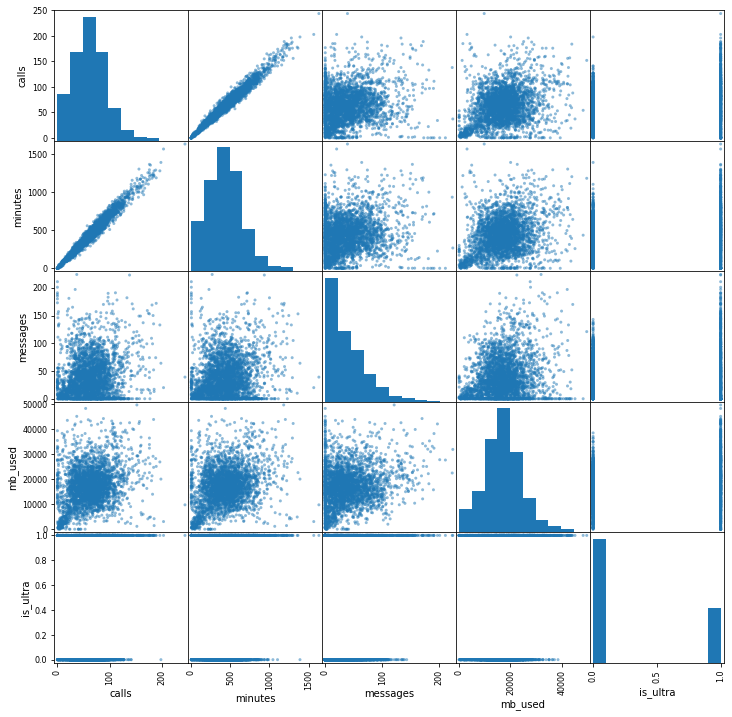

Корелляция данных:


,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.98,0.18,0.29,0.21
minutes,0.98,1.00,0.17,0.28,0.21
messages,0.18,0.17,1.00,0.20,0.20
mb_used,0.29,0.28,0.20,1.00,0.20
is_ultra,0.21,0.21,0.20,0.20,1.00


Столбцы: 

calls - количество звонков

Описание данных:
count   3,214.00
mean       63.04
std        33.24
min         0.00
25%        40.00
50%        62.00
75%        82.00
max       244.00
Name: calls, dtype: float64
Количество записей: 3214 из 3214

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


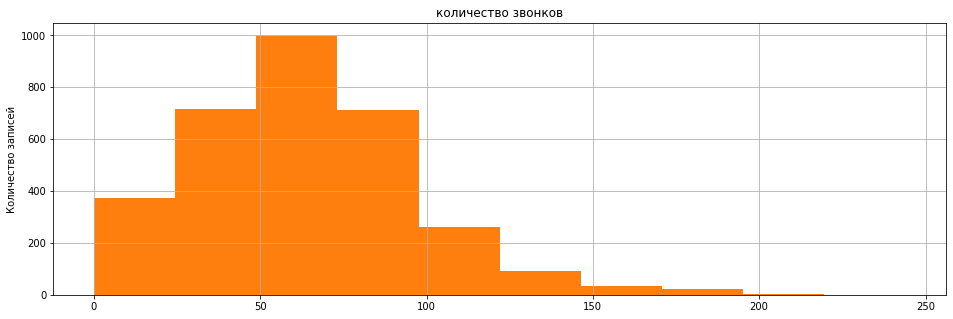


minutes - суммарная длительность звонков в минутах

Описание данных:
count   3,214.00
mean      438.21
std       234.57
min         0.00
25%       274.58
50%       430.60
75%       571.93
max     1,632.06
Name: minutes, dtype: float64
Количество записей: 3214 из 3214

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


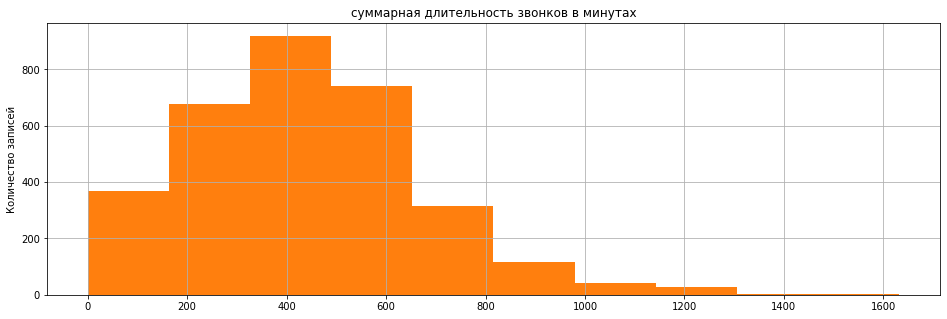


messages - количество sms-сообщений

Описание данных:
count   3,214.00
mean       38.28
std        36.15
min         0.00
25%         9.00
50%        30.00
75%        57.00
max       224.00
Name: messages, dtype: float64
Количество записей: 3214 из 3214

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


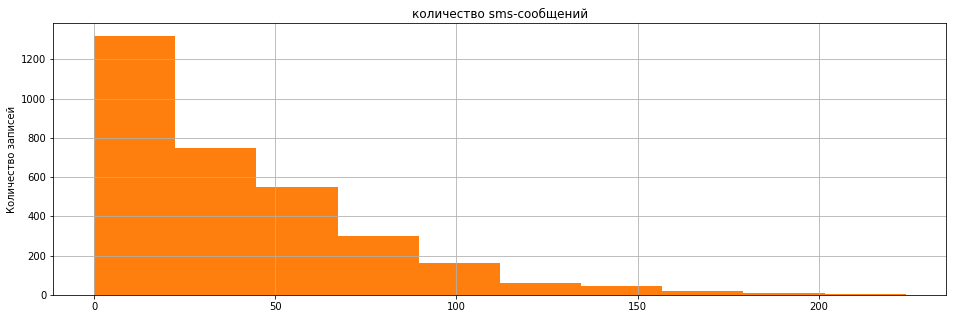


mb_used - израсходованный интернет-трафик в Мб

Описание данных:
count    3,214.00
mean    17,207.67
std      7,570.97
min          0.00
25%     12,491.90
50%     16,943.24
75%     21,424.70
max     49,745.73
Name: mb_used, dtype: float64
Количество записей: 3214 из 3214

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


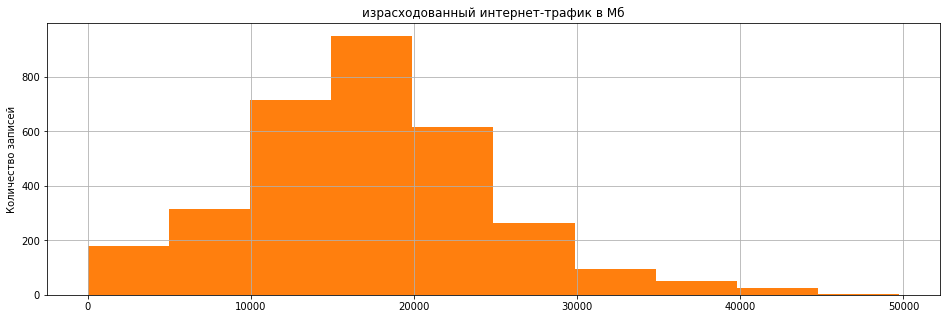


is_ultra - каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

Описание данных:
count   3,214.00
mean        0.31
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: is_ultra, dtype: float64
Количество записей: 3214 из 3214

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


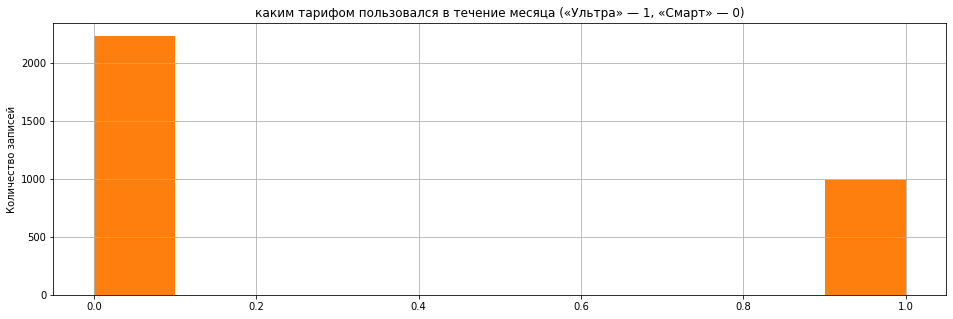

In [9]:
df_reaper(data, data_name, data_fields)

### Общий вывод анализа входной информации

1. В предоставленных данных находится информация о 3214 абонетах мобильной связи.
2. Все данные полны, пропущенные данные отсутствуют.
3. В данных отсутствуют аномальные выбросы.
4. Присутствует слабая зависимость между выбором тарифа и каждым из параметров в отдельности.
5. Более 2/3 абонентов пользуется тарифом "Смарт".
6. В качестве целевого признака можно использовать значение столбца ***is_ultra***

## Разбейте данные на выборки

Выделим признаки и целевой признак - столбец ***is_ultra***

In [10]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

Разобъем данные на тренировочную, валидационную и тестовую выборку в пропорции 60:20:20

In [11]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify = target_valid_test)

Проверка:

In [12]:
len(features_train)/len(features)

0.5998755444928439

In [13]:
len(features_valid)/len(features)

0.2000622277535781

In [14]:
len(features_test)/len(features)

0.2000622277535781

**Итог:**

Данные разбиты на тренировочную, валидационную и тестовую выборку в пропорции 60:20:20

## Исследуйте модели

### Модель "Решающее дерево"

#### Поиск оптимальных гиперпараметров:

In [15]:
best_model = None
best_result = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid,predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

#### Accuracy наилучшей модели на валидационной выборке:

In [16]:
 best_result

0.80248833592535

#### Модель "Решающее дерево" с наилучшим значением аccuracy: 

In [17]:
model_tree = best_model
model_tree

DecisionTreeClassifier(max_depth=8, random_state=12345)

### Модель "Случайный лес"

#### Поиск оптимальных гиперпараметров:

In [18]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid,predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

#### Accuracy наилучшей модели на валидационной выборке:

In [19]:
 best_result

0.8227060653188181

#### Модель "Случайный лес" с наилучшим значением аccuracy: 

In [20]:
model_forest = best_model
model_forest

RandomForestClassifier(max_depth=9, n_estimators=39, random_state=12345)

### Модель "Логистическая регрессия"

#### Обучение модели:

In [21]:
model_regress = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_regress.fit(features_train, target_train)
model_regress

LogisticRegression(max_iter=1000, random_state=12345)

#### Accuracy наилучшей модели на валидационной выборке:

In [22]:
predictions_valid = model_regress.predict(features_valid)
accuracy_score(target_valid,predictions_valid)

0.7387247278382582

### Итог исследования моделей:

На валидационной выборке:<br />
1. Модель **"Решающее дерево"** (макс. глубина  - 8) имеет accuracy = 0.802
2. Модель **"Случайный лес"** (макс. глубина  - 9, кол-во деревьев - 39) имеет accuracy = 0.823
3. Модель **"Логистическая регрессия"** имеет accuracy = 0.739<br />
<br />
4. Наилучший результат показывает **"Случайный лес"**, наихудший - **"Логистическая регрессия"**

## Проверьте модель на тестовой выборке

### Модель "Решающее дерево"

In [23]:
predictions_tree = model_tree.predict(features_test)
result_tree = accuracy_score(target_test,predictions_tree)
result_tree    

0.7838258164852255

Accuracy незначительно уменьшилось - на 2,2%

### Модель "Случайный лес"

In [24]:
predictions_forest = model_forest.predict(features_test)
result_forest = accuracy_score(target_test,predictions_forest)
result_forest  

0.8118195956454122

Отличие еще меньше - на 1,3%

### Модель "Логистическая регрессия"

In [25]:
predictions_regress = model_regress.predict(features_test)
result_regress = accuracy_score(target_test,predictions_regress)
result_regress  

0.7465007776049767

Даже улучшилась - на 1,1%

### Выводы:

#### На тестовой выборке:<br />
1. Модель **"Решающее дерево"** (макс. глубина  - 8) имеет accuracy = 0.784<br /> 
(ухудшение по сравнению с валидационной выборкой - 2.2%)
2. Модель **"Случайный лес"** (макс. глубина  - 9, кол-во деревьев - 39) имеет accuracy = 0.812
<br /> 
(ухудшение по сравнению с валидационной выборкой - 1.3%)
3. Модель **"Логистическая регрессия"** имеет accuracy = 0.747<br />
(улучшение по сравнению с валидационной выборкой - 1.1%)<br />
<br />
4. Наилучший результат показывает **"Случайный лес"** (макс. глубина  - 8, кол-во деревьев - 40) , наихудший - **"Логистическая регрессия"**

## (бонус) Проверьте модели на адекватность

Для проверки используем фальшивую модель **DummyClassifier**. Поскольку результат бинарен, достаточно использовать стратегии 'most_frequent', 'stratified' и 'uniform' (стратегии 'prior' и 'constant' (при заданном значении 0, как наиболее распространенном) будут выдавать тот же результат, что и  'most_frequent')

In [26]:
strategies = ['most_frequent','stratified', 'uniform']  
for s in strategies:
    dclf = DummyClassifier(strategy = s, random_state = 12345)
    dclf.fit(features_train, target_train)
    print(s,'\t', dclf.score(features_train, target_train))    

most_frequent 	 0.6934647302904564
stratified 	 0.5809128630705395
uniform 	 0.4880705394190871


**Вывод** <br />
Все модели применительно к исходному набору данных) - адекватны: их значение accuracy значительно превышает предсказания **DummyClassifier**,<br />

## Итоги проекта:

### Анализ исходной информации:
1. В предоставленных данных находится информация о 3214 абонетах мобильной связи.
2. Все данные полны, пропущенные данные отсутствуют.
3. В данных отсутствуют аномальные выбросы.
4. Присутствует слабая зависимость между выбором тарифа и каждым из параметров в отдельности.
5. Более 2/3 абонентов пользуется тарифом "Смарт".
6. В качестве целевого признака можно использовать значение столбца ***is_ultra***

### Моделирование:
#### Данные разбиты на тренировочную, валидационную и тестовую выборку в пропорции 60:20:20
#### На валидационной выборке:<br />
- Модель **"Решающее дерево"** (макс. глубина  - 8) имеет accuracy = 0.802
- Модель **"Случайный лес"** (макс. глубина  - 9, кол-во деревьев - 39) имеет accuracy = 0.823
- Модель **"Логистическая регрессия"** имеет accuracy = 0.739<br />
- Наилучший результат показывает **"Случайный лес"**, наихудший - **"Логистическая регрессия"**<br />
#### На тестовой выборке:<br />
- Модель **"Решающее дерево"** (макс. глубина  - 8) имеет accuracy = 0.784<br /> 
(ухудшение по сравнению с валидационной выборкой - 2.2%)
- Модель **"Случайный лес"** (макс. глубина  - 9, кол-во деревьев - 39) имеет accuracy = 0.812
<br /> 
(ухудшение по сравнению с валидационной выборкой - 1.3%)
- Модель **"Логистическая регрессия"** имеет accuracy = 0.747<br />
(улучшение по сравнению с валидационной выборкой - 1.1%)<br />
<br />
- Наилучший результат показывает **"Случайный лес"** (макс. глубина - 8, кол-во деревьев - 40) , наихудший - **"Логистическая регрессия"**
#### Проверка адекватности моделей:<br />
- Все модели (применительно к исходному набору данных) - адекватны: их значение accuracy значительно превышает предсказания **DummyClassifier**<br />

### Итог
Для выбора подходящего тарифа рекомендуется использовать модель **"Случайный лес"** с гиперпараметрами:
- макс. глубина - 9;
- кол-во деревьев - 39